# Master Thesis Analysis Report

Analysis of the participants using two different user interfaces. Participants had to fill out S-UEQ, SUS and RAW-TLX after a task on Garmin and a task on Strava. Each participant represents 2 rows in a dataframe - one row represents self-reports for Garmin (1) and one for Strava (2). To do an analysis, data has to be split into 3 distinct questionnaires.

In [1]:
from analysis.analyzer import AnalysisManager
from data_manager.manager import DataManager
import pandas as pd
import seaborn as sns


NOTE!! preden začneš delat z novimi podatki, uvoženimi iz 1ke, moraš zamenjat "=" in " s prazno. Lahko narediš v VSCju. 1. vrstica ima 2x 1 pri UI_category, 2. zamenjaj s 1. 97548 šifro mečemo ven

## Getting data ready

Reading data from a CSV file and changing values to numeric; column 1 is user ID, column 2 is category (1 - Garmin, 2 - Strava)

In [2]:
data_manager = DataManager(
    responses_data_path="anketa_new.csv", 
    pupil_data_path=None
    )

cleaned_data = data_manager.get_clean_data().iloc[2:,:]
cleaned_data.head(3)

,user_id,UI,Q4a,Q4b,Q4c,Q4d,Q4e,Q4f,Q4g,Q4h,...,Q6g,Q6h,Q6i,Q6j,Q8,Q9,Q10,Q11,Q12,Q13
2,29622,2,5,6,6,2,5,6,5,5,...,4,4,1,4,12,0,5,12,15,7
3,29622,1,6,6,6,7,3,5,6,6,...,5,1,4,2,8,0,5,5,8,2
4,94249,2,6,5,5,6,4,4,5,5,...,4,2,5,1,1,0,1,0,1,1


Checking for internal consistency of the questionnaire responses with Cronbach Alpha and its confidence intervals:

In [3]:
cronbach=data_manager.calculate_cronbach_alpha(cleaned_data)
cronbach

,Questionnaire,Cronbach's Alpha,CI Lower,CI Upper
0,UEQ Pragmatic Quality,0.8725,0.806,0.920
1,UEQ Hedonic Quality,0.8701,0.803,0.919
2,Overall UEQ Score,0.8453,0.774,0.901
3,SUS,0.7860,0.690,0.862
4,NASA-TLX,0.8179,0.731,0.884


We can see that internal consistency of the questionnaires is sufficient.

Splitting data into:
* short-user experience questionnaire (SUEQ)
* system usability scale (SUEQ)
* NASA task load index (NASA-TLX)

In [4]:
sueq, sus, tlx = data_manager.split_data()
questionnaire_dict= {"SUEQ" : sueq, 
                     "SUS" : sus, 
                     "TLX" : tlx}
sueq.head(3)

,user_id,UI,Q4a,Q4b,Q4c,Q4d,Q4e,Q4f,Q4g,Q4h
0,83213,1,5,5,6,6,6,6,4,3
1,83213,2,4,3,5,5,5,5,3,2
2,29622,2,5,6,6,2,5,6,5,5


## Scoring data
Initializing class Analysis and performing a scoring on each questionnaire.

In [5]:
analyst=AnalysisManager(sueq, sus, tlx)

In [6]:
score_tlx=analyst.score_tlx()
score_tlx.head()

,User ID,Interface Category,Mean TLX Score
0,83213,1,4.166667
1,83213,2,1.666667
2,29622,2,8.500000
3,29622,1,4.666667
4,94249,2,0.666667


In [7]:
score_sus=analyst.score_sus()
score_sus.head()

,User ID,Interface Category,Mean SUS Score
0,83213,1,62.5
1,83213,2,52.5
2,29622,2,45.0
3,29622,1,87.5
4,94249,2,80.0


In [8]:
score_sueq=analyst.score_ueq_short()
score_sueq.head()

,User ID,Interface Category,Overall Pragmatic Quality,Overall Hedonic Quality,Overall UEQ Score
0,83213,1,5.50,4.75,5.125
1,83213,2,4.25,3.75,4.000
2,29622,2,4.75,5.25,5.000
3,29622,1,6.25,5.00,5.625
4,94249,2,5.50,4.50,5.000


In [9]:
combined_scores=analyst.combine_scores(score_sueq, score_sus, score_tlx)
combined_scores.head()

,User ID,Interface Category,Overall Pragmatic Quality,Overall Hedonic Quality,Overall UEQ Score,Mean SUS Score,Mean TLX Score
0,14076,1,4.75,3.00,3.875,50.0,-3.000000
1,14076,2,3.00,4.00,3.500,57.5,5.833333
2,14230,1,6.25,5.75,6.000,92.5,1.833333
3,14230,2,5.50,5.25,5.375,80.0,3.166667
4,15629,1,4.00,3.75,3.875,62.5,5.000000


In [10]:
#combined_scores.to_csv('combined_scores.csv', index=False)

## Visualizing data
Below is a chart of average scores on Questionnaires based on Interface. From the visualization alone we can see no significant difference in scores depending on interface

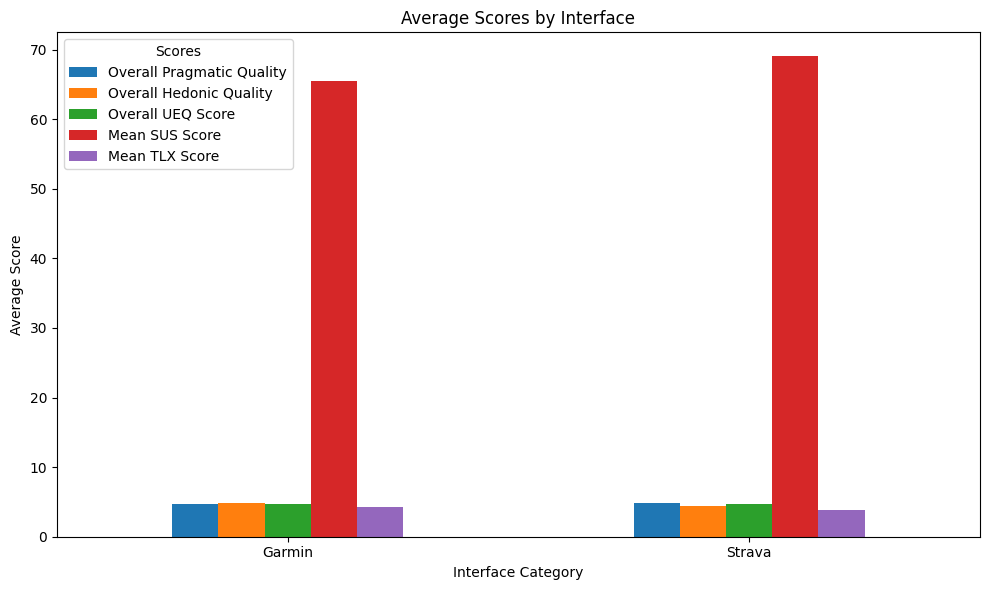

In [11]:
analyst.visualize_scores(combined_scores)

We performed t-test analysis for repeated measures to compare the scores of the two groups. The results are as follows:

In [12]:
t_statistics=analyst.t_stat(combined_scores)
t_statistics

,Measure,T-Statistic,P-Value
0,Overall Pragmatic Quality,-0.6435,0.5255
1,Overall Hedonic Quality,1.1824,0.2477
2,Overall UEQ Score,0.1614,0.8730
3,Mean SUS Score,-0.6297,0.5344
4,Mean TLX Score,0.6420,0.5265


No significant relationship between interface and its questionnaire scores was found. 

## Combining questionnaire data with interface order and perceived difficulty
In the experiment, we used random order in which interfaces were presented, together with the question "Which interface did you find harder to solve the task on
?" [slov. Na katerem vmesniku je bilo težje reševati nalogo?] at the end of the whole experiment. 
* UI order ; 1 means interface was presented first, 2 means it was presented second
* UI rank; interface was ranked so that 1 means harder than 2

In [13]:
full_data=pd.read_csv("updated_combined_scores.csv", delimiter=";")
full_data.head(3)

,User ID,Interface Category,UI order,UI rank,Overall Pragmatic Quality,Overall Hedonic Quality,Overall UEQ Score,Mean SUS Score,Mean TLX Score
0,14230,1,2,2,6.25,5.75,6.000,92.5,1.833333
1,14230,2,1,1,5.50,5.25,5.375,80.0,3.166667
2,15629,1,1,1,4.00,3.75,3.875,62.5,5.000000


Adding information about gender and checking for relationships between gender and questionnaire answers

In [14]:
score_columns = [
    'Overall Pragmatic Quality',
    'Overall Hedonic Quality',
    'Overall UEQ Score',
    'Mean SUS Score',
    'Mean TLX Score'
]
independent_variables = ['Interface Category', 'UI rank', 'UI order', 'Gender']

list_females=[
    83213, 63367, 60734, 37786, 74931, 16836, 39081, 62968, 84586, 16063,
    31434, 15629, 24603, 40280, 69163, 14076, 96066
]
data_manager.assign_gender(full_data, list_females)
analyst.gender_cor(full_data, score_columns)

,Score Column,Correlation (r),P-Value
0,Overall pragmatic quality,-0.0500,0.7145
1,Overall hedonic quality,0.0102,0.9407
2,Overall ueq score,-0.0264,0.8468
3,Mean sus score,-0.0041,0.9761
4,Mean tlx score,0.0837,0.5395


In [15]:

# Compute Cohen's d for Interface Category
cohen_d_interface_category = analyst.calculate_cohen_d(full_data, 'Interface Category', score_columns)
print("Cohen's d by Interface Category: 1 means Garmin whereas 2 means Strava")
print(cohen_d_interface_category)

# Compute Cohen's d for UI Order
cohen_d_ui_order = analyst.calculate_cohen_d(full_data, 'UI order', score_columns)
print("\nCohen's d by UI Order: 1 means it was presented first, 2 means it was presented second")
print(cohen_d_ui_order)

# Compute Cohen's d for UI Ranking
cohen_d_ui_ranking = analyst.calculate_cohen_d(full_data, 'UI rank', score_columns)
print("\nCohen's d by UI Ranking: 1 means it was ranked as harder, 2 means it was ranked as easier")
print(cohen_d_ui_ranking)

#compute Cohen's d for Gender
cohen_d_gender = analyst.calculate_cohen_d(full_data, 'Gender', score_columns)
print("\nCohen's d by Gender:")
print(cohen_d_gender)

Cohen's d by Interface Category: 1 means Garmin whereas 2 means Strava
                     Measure   Grouping Variable  Group 1  Group 2  Cohen's d
0  Overall Pragmatic Quality  Interface Category        1        2    -0.1529
1    Overall Hedonic Quality  Interface Category        1        2     0.2645
2          Overall UEQ Score  Interface Category        1        2     0.0532
3             Mean SUS Score  Interface Category        1        2    -0.2011
4             Mean TLX Score  Interface Category        1        2     0.0634

Cohen's d by UI Order: 1 means it was presented first, 2 means it was presented second
                     Measure Grouping Variable  Group 1  Group 2  Cohen's d
0  Overall Pragmatic Quality          UI order        2        1    -0.3152
1    Overall Hedonic Quality          UI order        2        1     0.0908
2          Overall UEQ Score          UI order        2        1    -0.1490
3             Mean SUS Score          UI order        2        1    -

Effect size is neglible for all independent variables but shows moderate effect in UI rank; interface perceived as harder scores lower on all questionnaires and subquestionnaires (UEQ, SUS) but higher on TLX, suggesting user experience is worse while perceived load is higher in interface subjectively perceived as harder. 

In [16]:
correlations, ttests =analyst.correlations_and_ttests(full_data)

We did an exploraty data analysis by correlating different variables. We were interested in the following relationships:
* is there a correlation between the order in which the interface was presented and perceived difficulty of task solving
* is there a correlation between the order in which the interface was presented and its scores on the questionnaires
* is there a correlation between the ranking of the interface and its scores on the questionnaires

For correlating UI order and UI rank, phi coefficient was used. For correlating UI order and UI rank with questionnaire scores, point biserial was used

In [17]:
corr_table, ttest_table =analyst.present_findings(correlations, ttests)
corr_table

,Relationship,Correlation (r),P-Value
0,UI rank ↔ UI order,0.25,Phi coefficient (no p-value)
1,UI rank ↔ Overall Pragmatic Quality,0.30*,0.0266
2,UI order ↔ Overall Pragmatic Quality,-0.16,0.2434
3,UI rank ↔ Overall Hedonic Quality,0.30*,0.0246
4,UI order ↔ Overall Hedonic Quality,0.05,0.7354
5,UI rank ↔ Overall UEQ Score,0.36**,0.0057
6,UI order ↔ Overall UEQ Score,-0.08,0.5794
7,UI rank ↔ Mean SUS Score,0.27*,0.0463
8,UI order ↔ Mean SUS Score,-0.08,0.5757
9,UI rank ↔ Mean TLX Score,-0.25,0.0584


Correlation between UI rank and UI order is fairly weak. UI rank correlates significantly with overall pragmatic and hedonic quality, overall UEQ score and mean SUS score. However we can see that effect size is quite small. 

In [18]:
ttest_table

,Measure,Grouping Variable,T-Statistic (t),P-Value
0,Overall Pragmatic Quality,UI rank,-2.29*,0.0304
1,Overall Hedonic Quality,UI rank,-2.69*,0.0122
2,Overall UEQ Score,UI rank,-3.28**,0.0030
3,Mean SUS Score,UI rank,-2.23*,0.0345
4,Mean TLX Score,UI rank,2.34*,0.0272
5,Overall Pragmatic Quality,UI order,1.20,0.2398
6,Overall Hedonic Quality,UI order,-0.37,0.7162
7,Overall UEQ Score,UI order,0.64,0.5270
8,Mean SUS Score,UI order,0.56,0.5777
9,Mean TLX Score,UI order,0.57,0.5766


A dependent samples t-test was conducted to compare questionnaire scores with UI rank and UI order. There was a significant difference in scores depending on perceived difficulty of the interface. 

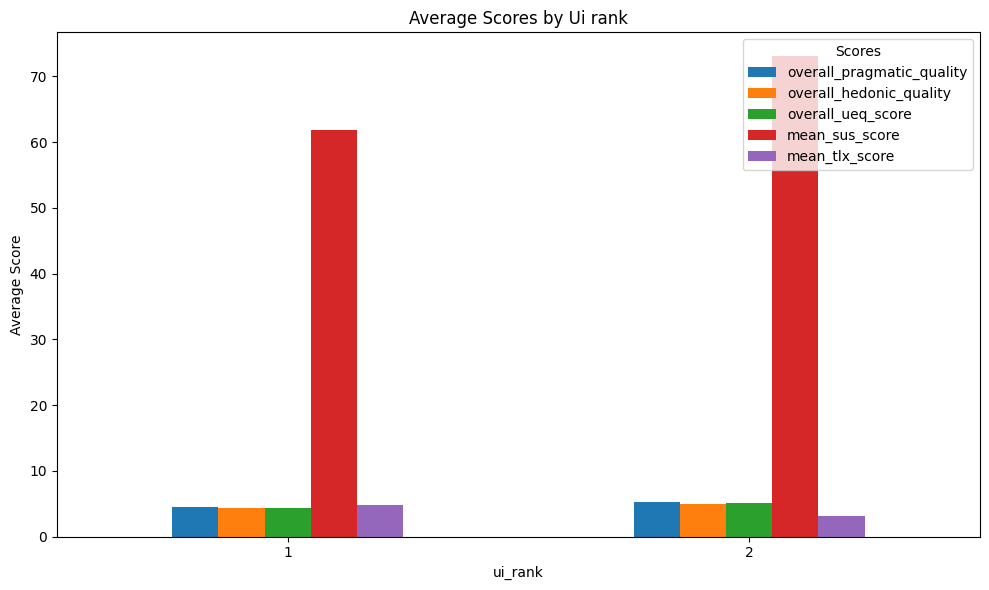

In [19]:
analyst.visualize_scores_by(full_data, 'UI rank')

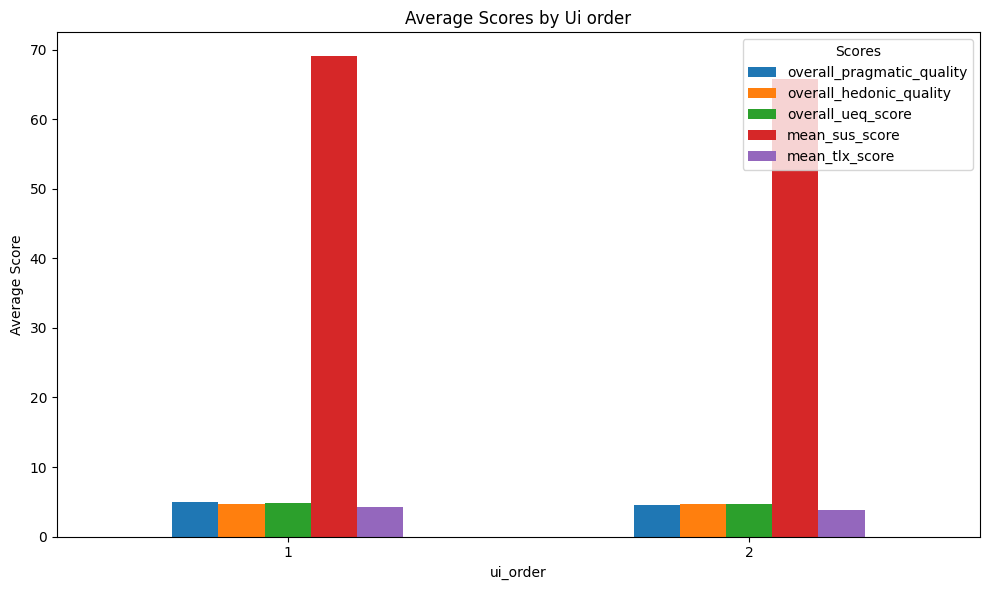

In [20]:
analyst.visualize_scores_by(full_data, 'UI order')

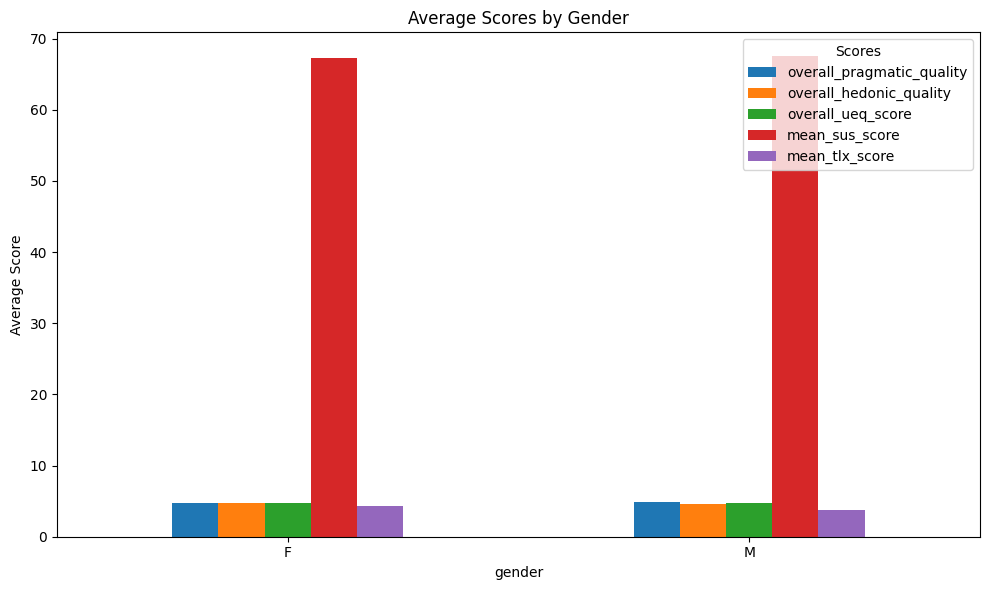

In [21]:
analyst.visualize_scores_by(full_data, 'Gender')

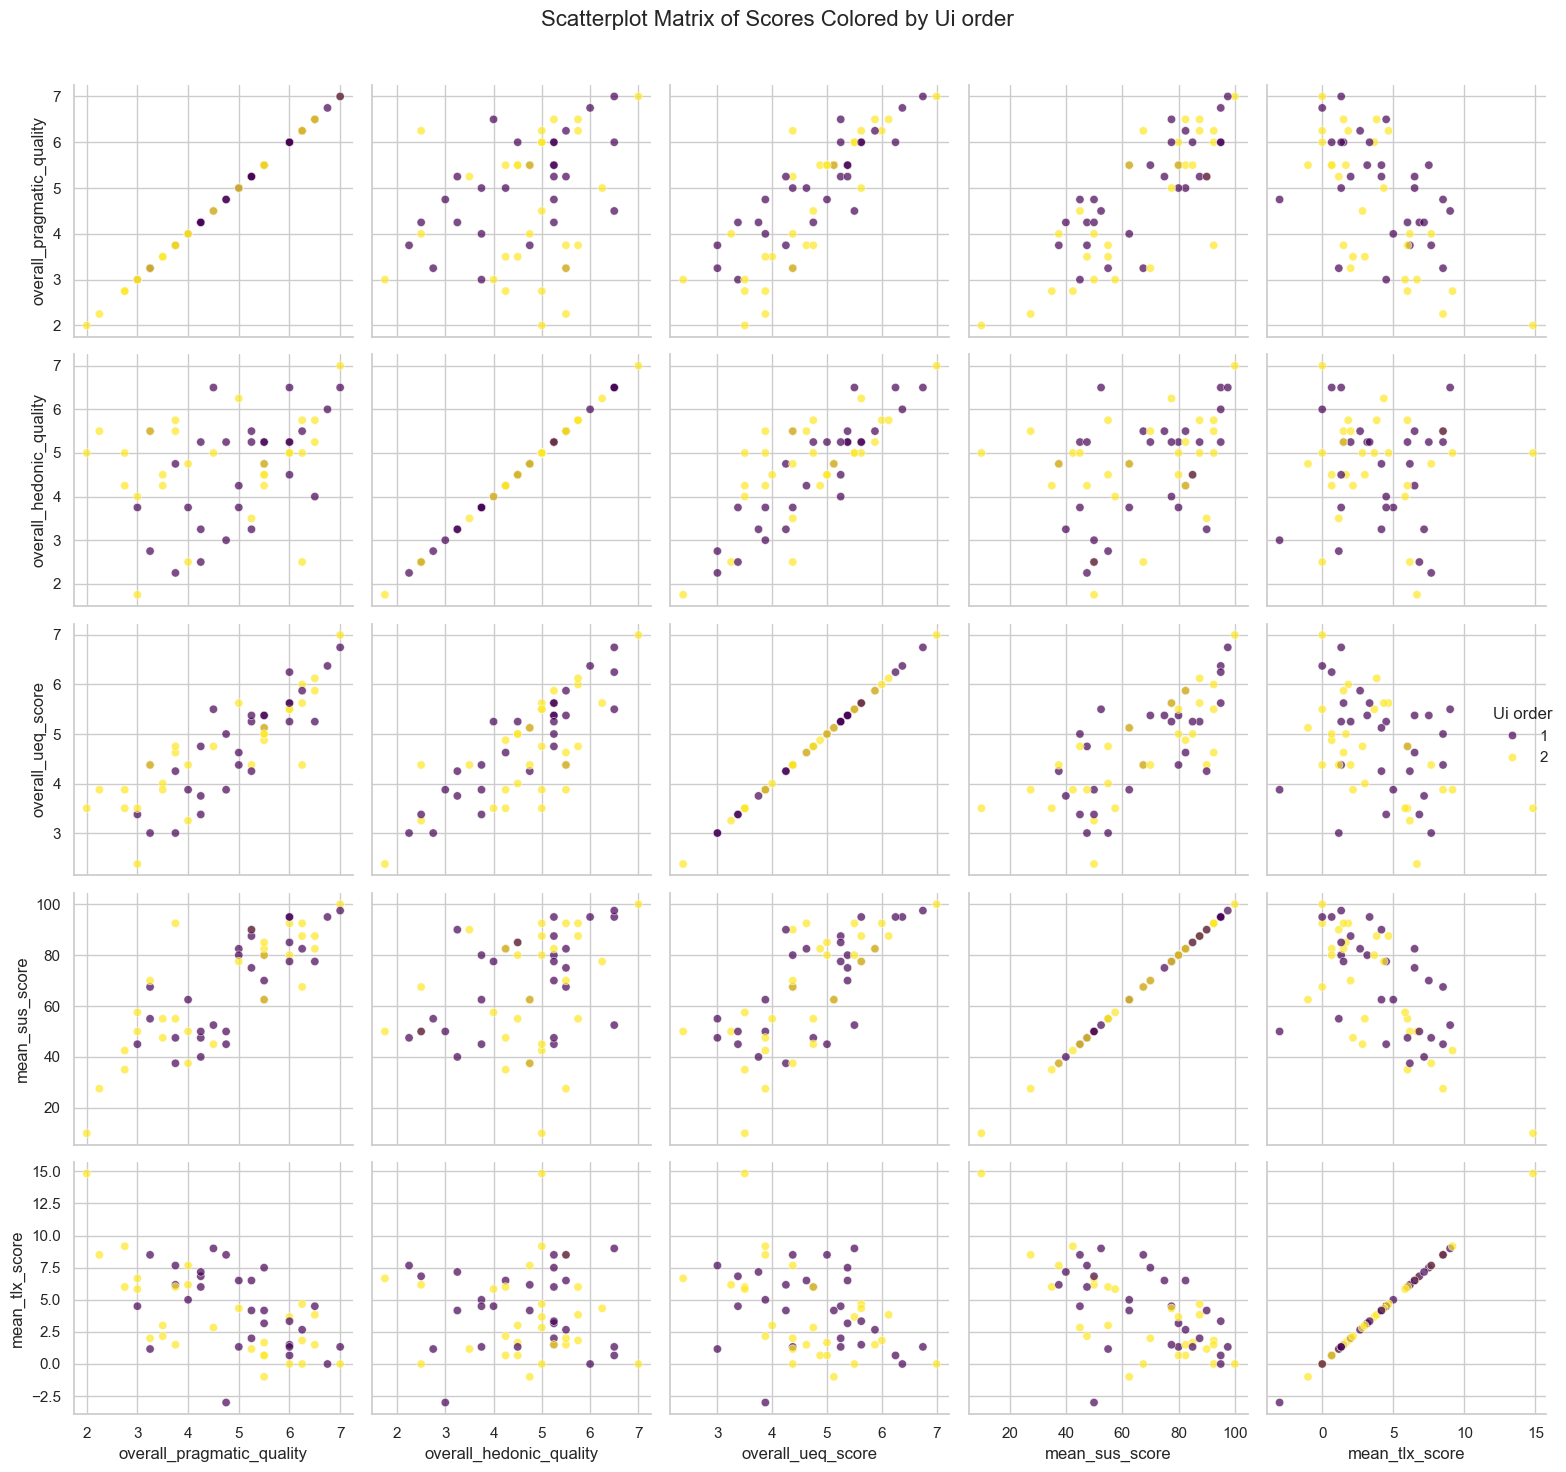

In [22]:
analyst.scatter_matrix(full_data, score_columns, 'UI order')

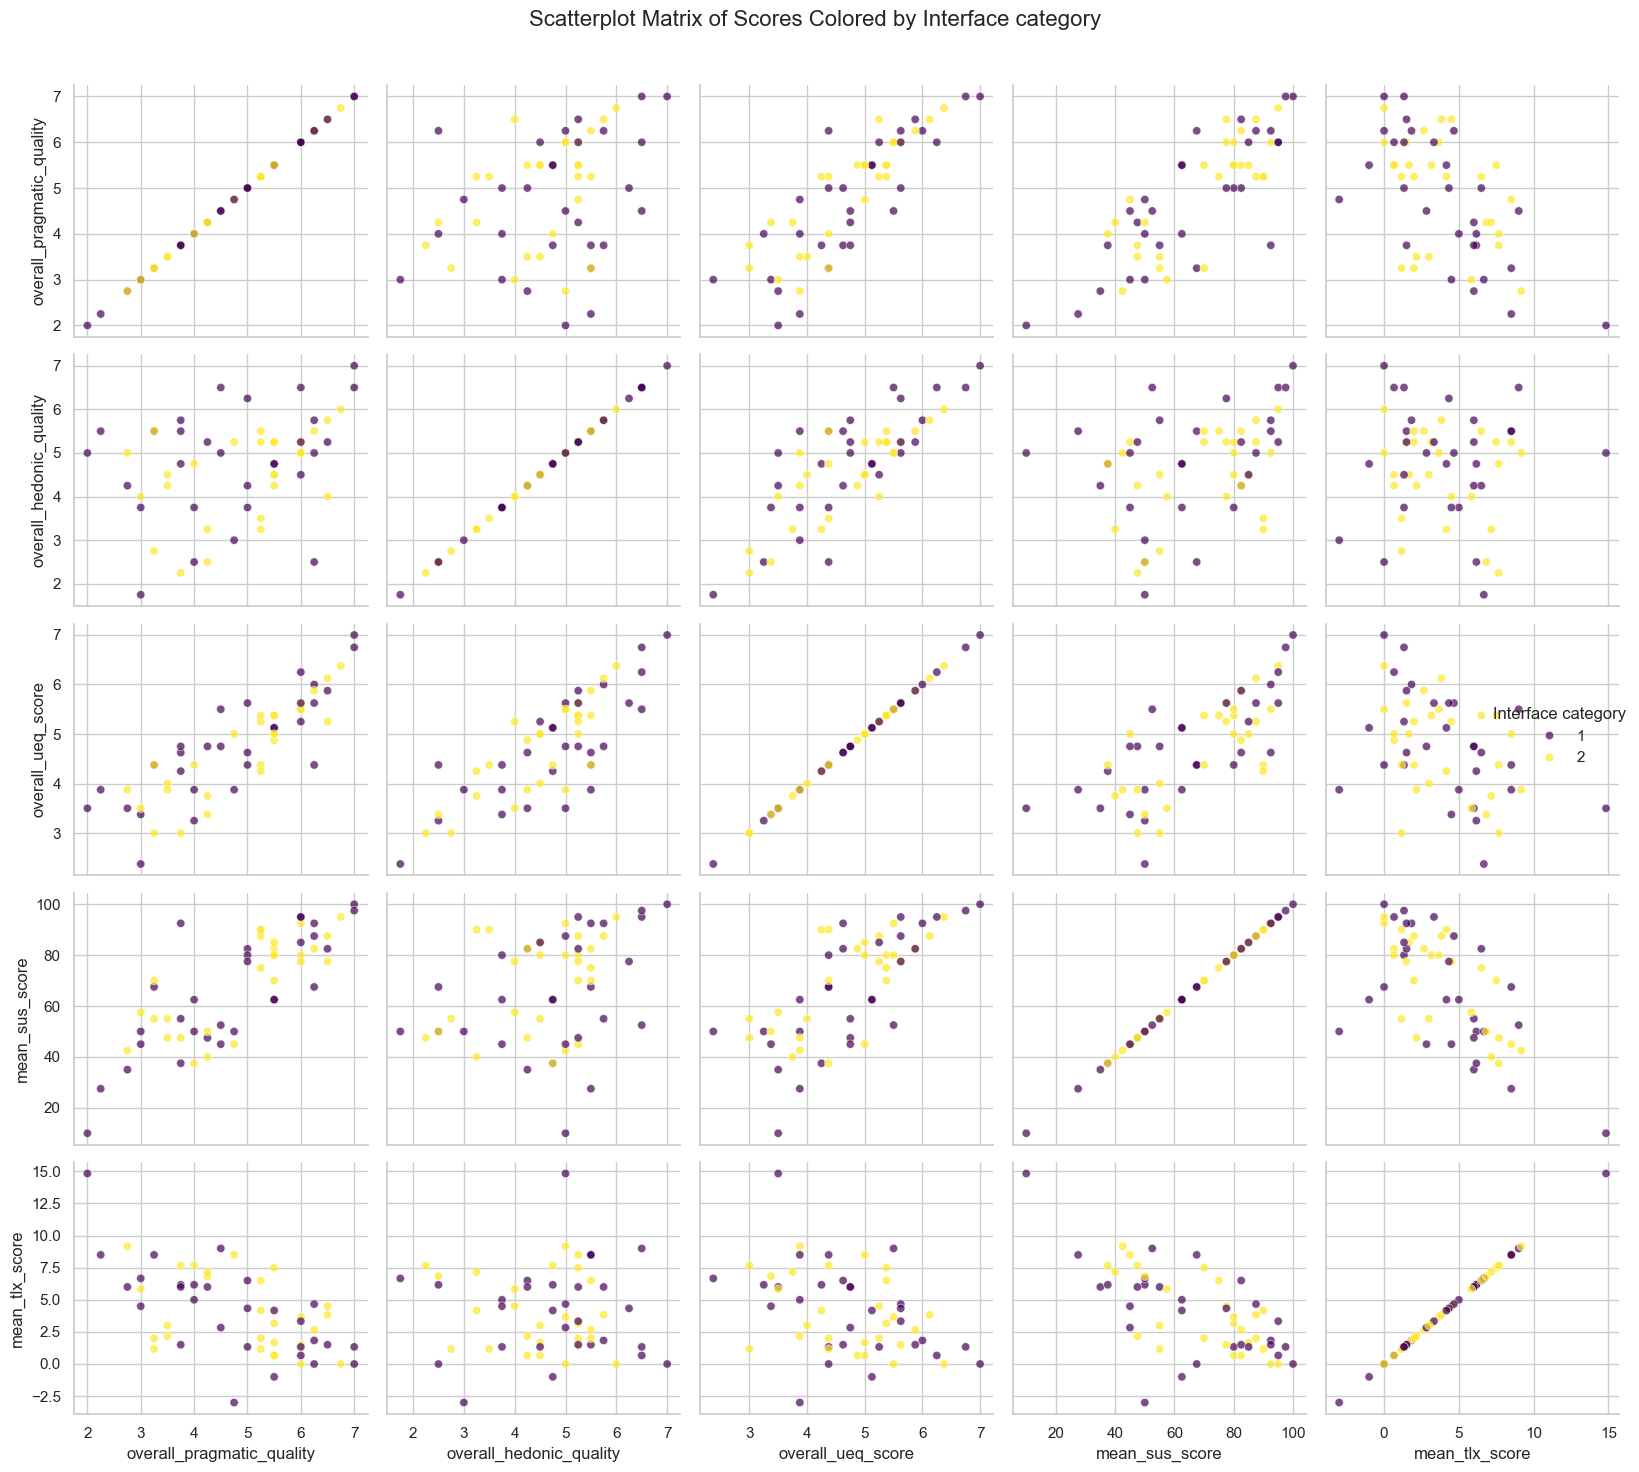

In [23]:
analyst.scatter_matrix(full_data, score_columns, 'Interface Category')

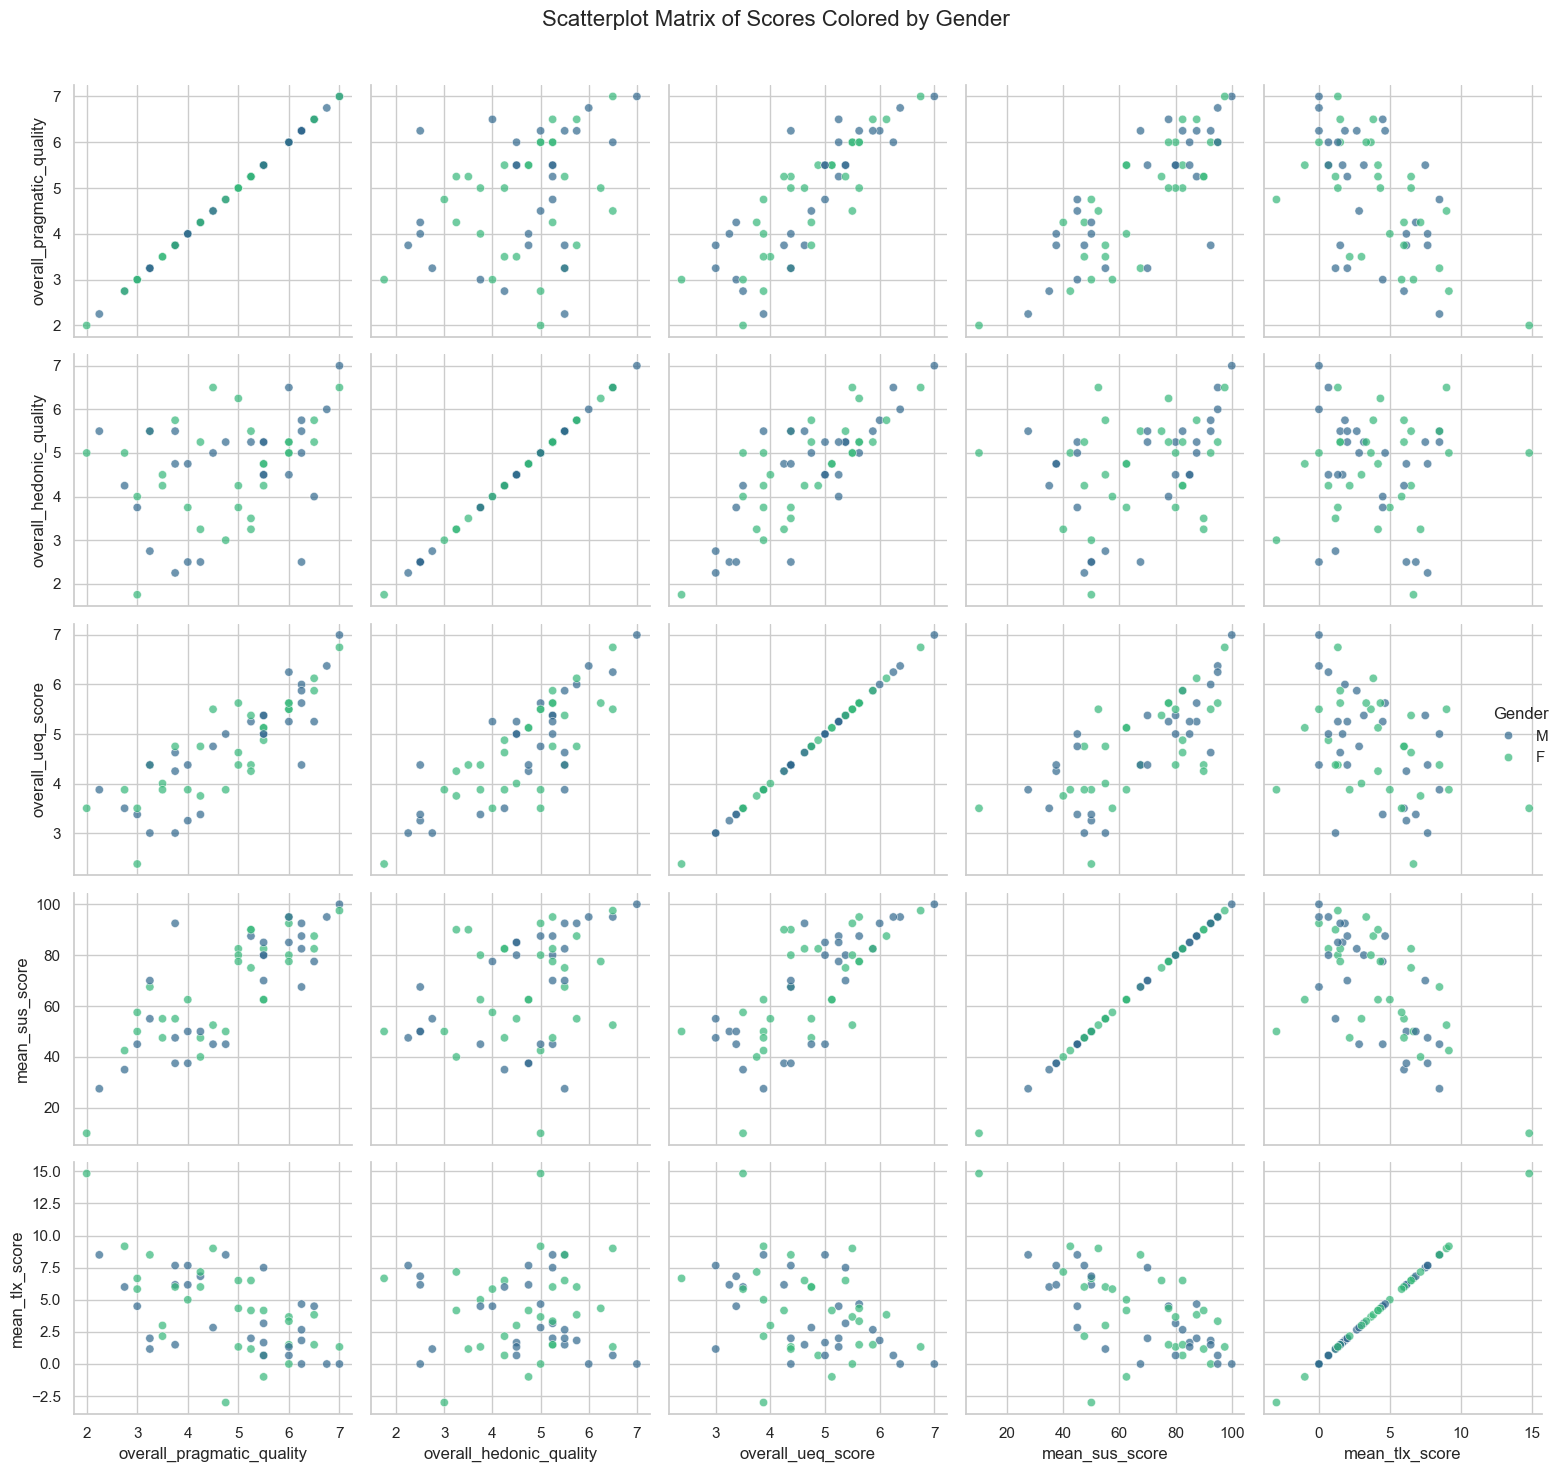

In [24]:
analyst.scatter_matrix(full_data, score_columns, 'Gender')

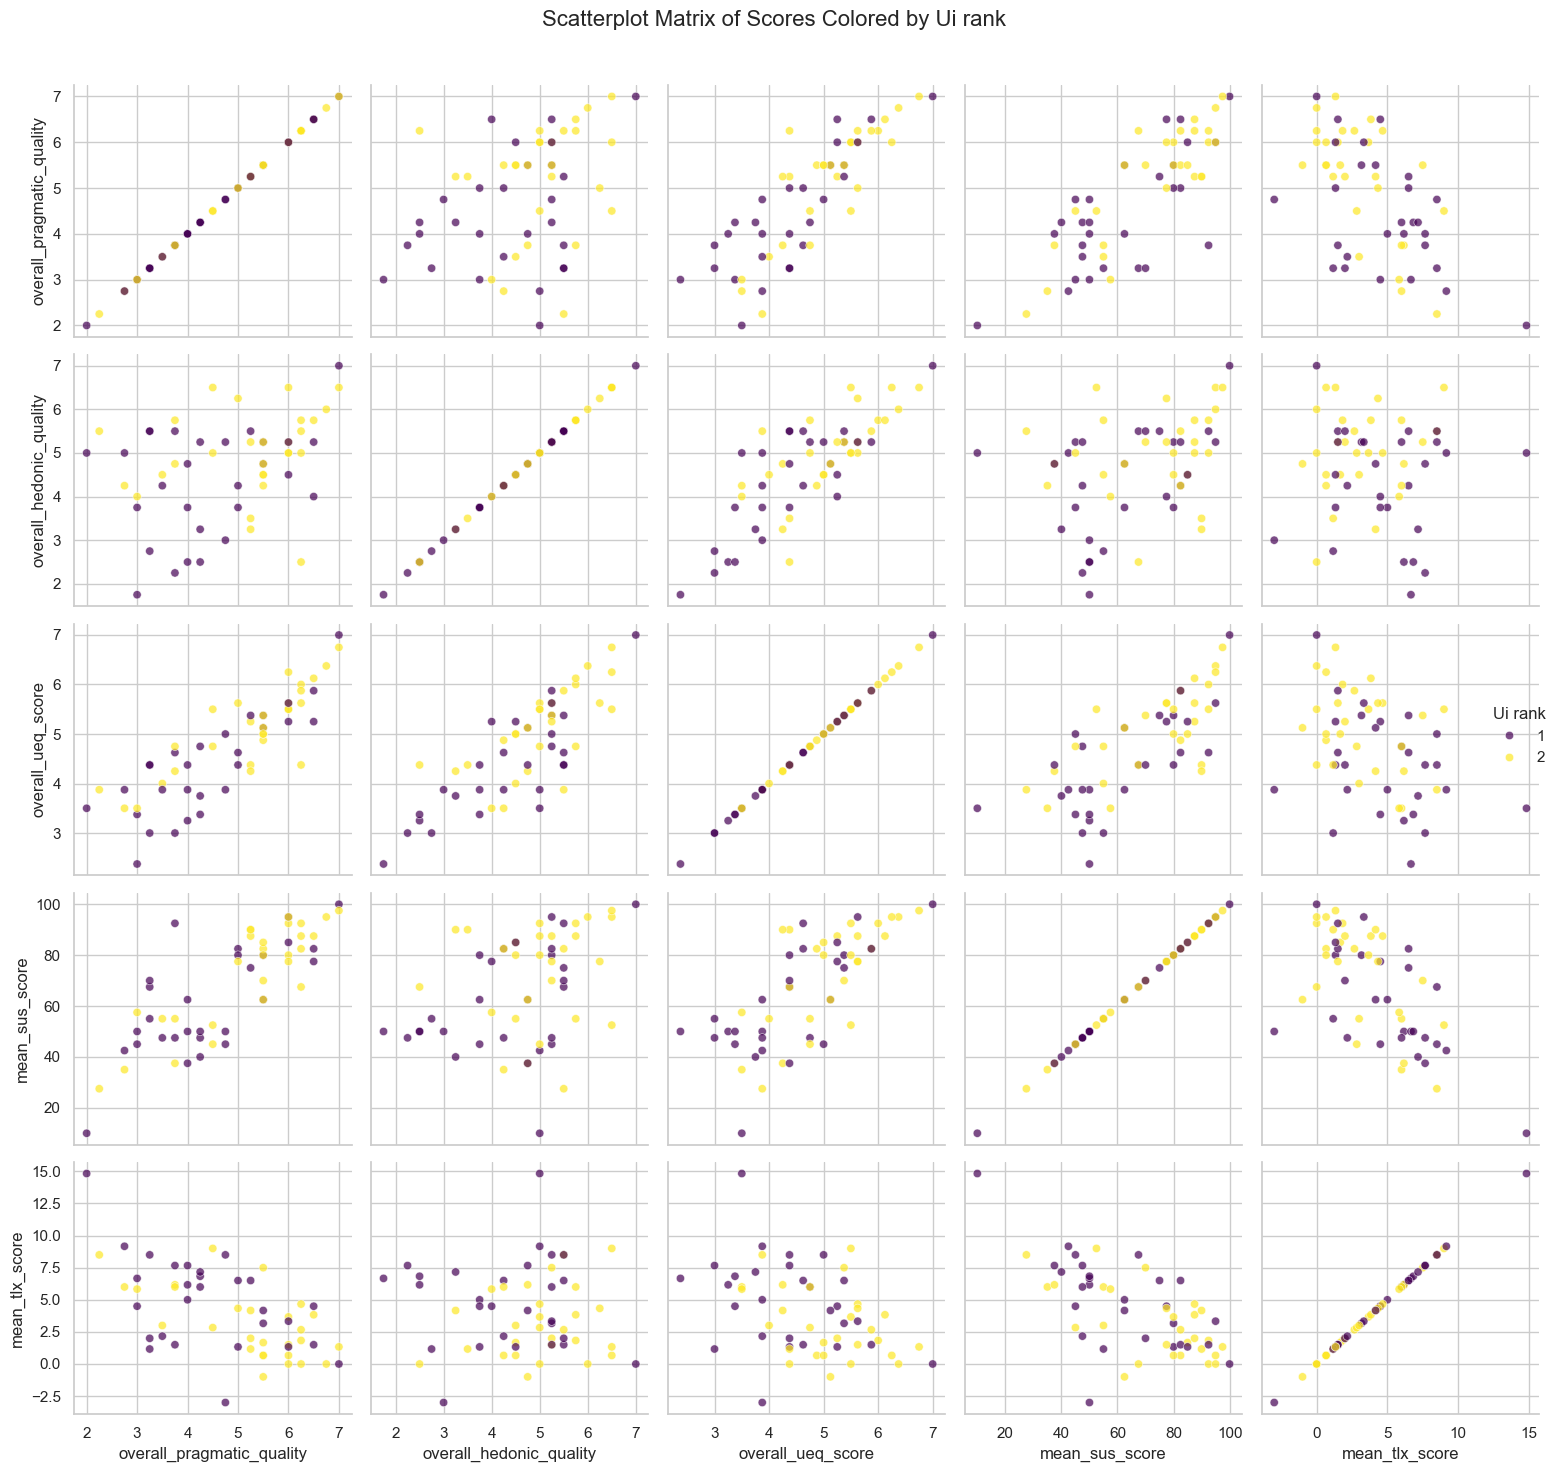

In [25]:
analyst.scatter_matrix(full_data, score_columns, 'UI rank')